# Demo: Transpiling DeepMind's PerceiverIO

In this example, we will `unify` and `transpile` a classifier built on top of DeepMind's original implementation of the PerceiverIO module written in JAX!

## Table of Contents
* [Defining the model](#defining-the-model)
* [Some helper functions ](#some-helper-functions)
* [Getting images (and noise!) for the classifier](#images)
* [Compiling the model](#compiling)
* [Unifying the model](#unifying)
* [Transpiling the model](#transpiling)

First of all, let's import **Ivy 🚀**

In [1]:
import ivy
from graph_compiler import compile
from transpiler.transpiler import unify, transpile

2023-01-13 16:05:01.516850: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-13 16:05:01.516868: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
Use `tf.GraphKeys.GLOBAL_VARIABLES` instead.


## Defining the model <a class="anchor" id="defining-the-model"></a>

(Psst! The PerceiverIO code we will use comes from [the original repo](https://github.com/deepmind/deepmind-research/tree/master/perceiver))

In order to define an image classifier on top of the PerceiverIO model, we must import some things first:

In [2]:
# utils
import os
import cv2
import pickle
import imageio
import urllib.request
# JAX imports
import jax
import jax.numpy as jnp
import numpy as np
import haiku as hk
rng = jax.random.PRNGKey(23)
# Perceiver implementation
from demos.perceiver_io.perceiver_io_deepmind import perceiver, io_processors
from demos.perceiver_io.perceiver_io_deepmind.imagenet_labels import IMAGENET_LABELS

We can now define the configuration of the Perceiver module

In [3]:
IMAGE_SIZE = (224, 224)

fourier_pos_configs = dict(
    input_preprocessor=dict(
        position_encoding_type="fourier",
        fourier_position_encoding_kwargs=dict(
            concat_pos=True, max_resolution=(224, 224), num_bands=64, sine_only=False
        ),
        prep_type="pixels",
        spatial_downsample=1,
    ),
    encoder=dict(
        cross_attend_widening_factor=1,
        cross_attention_shape_for_attn="kv",
        dropout_prob=0,
        num_blocks=8,
        num_cross_attend_heads=1,
        num_self_attend_heads=8,
        num_self_attends_per_block=6,
        num_z_channels=1024,
        self_attend_widening_factor=1,
        use_query_residual=True,
        z_index_dim=512,
        z_pos_enc_init_scale=0.02,
    ),
    decoder=dict(
        num_z_channels=1024,
        position_encoding_type="trainable",
        trainable_position_encoding_kwargs=dict(
            init_scale=0.02,
            num_channels=1024,
        ),
        use_query_residual=True,
    ),
)

Using the PerceiverIO module, we can now define an Imagenet classifier

In [4]:
def imagenet_classifier(config, images):
    input_preprocessor = io_processors.ImagePreprocessor(**config["input_preprocessor"])
    encoder = perceiver.PerceiverEncoder(**config["encoder"])
    decoder = perceiver.ClassificationDecoder(1000, **config["decoder"])
    model = perceiver.Perceiver(
        encoder=encoder, decoder=decoder, input_preprocessor=input_preprocessor
    )
    logits = model(images, is_training=False)
    return logits

In [5]:
imagenet_classifier = hk.transform_with_state(imagenet_classifier)

We also need to download the **original** parameters published by DeepMind if we want to save *some* computing 😅 

Thankfully Ivy will transform those for us as well 😉

In [6]:
cwd = os.getcwd()
checkpoint_path = os.path.join(cwd, "demos", "imagenet_checkpoint.pystate")
if not os.path.exists(checkpoint_path):
    url = "https://storage.googleapis.com/perceiver_io/imagenet_fourier_position_encoding.pystate"
    _ = urllib.request.urlretrieve(url, checkpoint_path)

with open(checkpoint_path, "rb") as f:
    ckpt = pickle.loads(f.read())

params = ckpt["params"]
state = ckpt["state"]

Finally, let's write a function that applies the downloaded parameters.

In [7]:
def imagenet_classify(image):
    return imagenet_classifier.apply(params, state, rng, fourier_pos_configs, image)

## Some helper functions <a class="anchor" id="some-helper-functions"></a>

In order to correctly use the classifier, we will need to define some **preprocessing functions**.

In [8]:
MEAN_RGB = (0.485 * 255, 0.456 * 255, 0.406 * 255)
STDDEV_RGB = (0.229 * 255, 0.224 * 255, 0.225 * 255)


def normalize(im):
    return (im - np.array(MEAN_RGB)) / np.array(STDDEV_RGB)

def denormalize(im):
    return im * np.array(STDDEV_RGB) + np.array(MEAN_RGB)


def resize_and_center_crop(image):
    """Crops to center of image with padding then scales."""
    shape = image.shape
    image_height = shape[0]
    image_width = shape[1]
    padded_center_crop_size = (
        (224 / (224 + 32)) * np.minimum(image_height, image_width).astype(np.float32)
    ).astype(np.int32)
    offset_height = ((image_height - padded_center_crop_size) + 1) // 2
    offset_width = ((image_width - padded_center_crop_size) + 1) // 2
    crop_window = [
        offset_height,
        offset_width,
        padded_center_crop_size,
        padded_center_crop_size,
    ]
    image = image[
        crop_window[0] : crop_window[0] + crop_window[2],
        crop_window[1] : crop_window[1] + crop_window[3],
    ]
    return cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC)

Same for the visualization of results, let's write some helpers to have nice outputs!

In [9]:
from matplotlib.pyplot import figure, imshow, axis

def print_labels(probs, indices):
    for i in list(indices):
        i = int(i)
        print(f"{IMAGENET_LABELS[i].split(',')[0][:15].ljust(20)}: {probs[i]}")

def show_images_row(images):
    fig = figure(figsize=(12,8))
    number_of_files = len(images)
    for i, image in enumerate(images):
        a=fig.add_subplot(1,number_of_files,i+1)
        imshow(np.array(image))
        axis('off')

def show_device_array(device_array):
    im = np.array(device_array[0])
    im = denormalize(im)
    im = im/256.0
    im = np.clip(im, 0, 1)
    fig = figure(figsize=(3,2))
    imshow(im)
    axis('off')

## Getting images (and noise!) for the classifier <a class="anchor" id="images"></a>

To compile and test the classifier we are going to need two types of images:
   - First, an image with random noise, which we will use to compile the graph while ensuring that input-specific information is **not** registered.
   - Secondly, a few images to test the compiled and transpiled models on!

In [10]:
test_urls = {
    "goldfish": "https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01443537_goldfish.JPEG",
    "roof": "https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n04435653_tile_roof.JPEG",
    "camera": "https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n04069434_reflex_camera.JPEG",
}
image_paths = {c: os.path.join(cwd, "demos", f"{c}.jpg") for c in test_urls.keys()}

for class_, image_path in image_paths.items():
    if not os.path.exists(image_path):
        url = test_urls[class_]
        _ = urllib.request.urlretrieve(url, image_path)
imgs = []

for image_path in image_paths.values():
    with open(image_path, "rb") as f:
        img = imageio.imread(f)
        img = resize_and_center_crop(img)
        imgs.append(img)

# generate noise
noise = np.random.uniform(size=(224, 224, 3))

Let's see what we got:

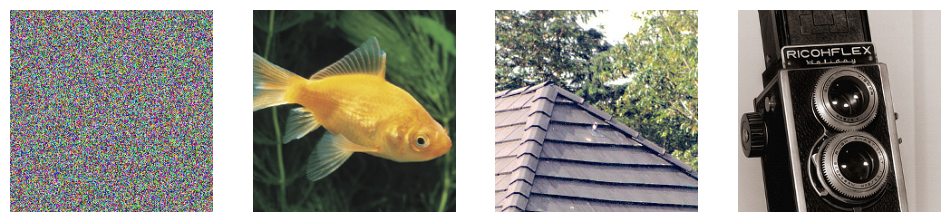

In [11]:
show_images_row([noise, *imgs])

Looking good! We can now convert the images to `jax.numpy.Array`s.

In [12]:
noise = jnp.expand_dims(jnp.array(noise), 0)

for i, img in enumerate(imgs):
    img = normalize(img)
    img = jnp.array(img)[None]
    imgs[i] = img

## Compiling the model <a class="anchor" id="compiling"></a>

The first thing we can do with the model is compiling it into a graph, this way, we remove any part of the code that doesn't contribute to the output directly which, you guessed it, makes it faster 🚀

In [13]:
ivy.set_backend("jax")
graph = compile(imagenet_classify, noise)

After compiling with the noisy image, let's use our first real image to check the inference speed and the accuracy of the compiled result.

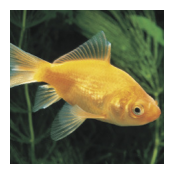

In [14]:
img = imgs[0]
show_device_array(img)

In [15]:
%%time
original_output, _ = imagenet_classify(img)

CPU times: user 38 s, sys: 3.75 s, total: 41.7 s
Wall time: 8.35 s


In [16]:
%%time
compiled_output, _ = graph(img)

CPU times: user 14.2 s, sys: 959 ms, total: 15.2 s
Wall time: 3.21 s


In [17]:
np.allclose(original_output, compiled_output, atol=0.0001)

True

As we can see above, the compiled graph is faster than the original model while yielding the same result!

## Unifying the model <a class="anchor" id="unifying"></a>

By **unifying** the model, we will get a model that can be used with **any ML framework**. Don't forget that we aren't just converting the inputs, all the operations within the model will happen in your framework of choice!

In [18]:
ivy_graph = unify(
    imagenet_classify,
    original_backend="jax",
    args=(noise,),
)

Let's pick the second image as an example:

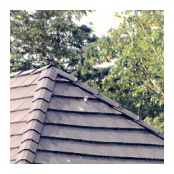

In [19]:
img = imgs[1]
show_device_array(img)

And calculate the output using each one of the frameworks:

In [20]:
original_logits, _ = imagenet_classify(img)

In [21]:
ivy.set_backend("jax")
jax_logits, _ = ivy_graph(img)
np.allclose(original_logits, jax_logits, atol=0.0001)

True

In [22]:
ivy.set_backend("torch")
torch_logits, _ = ivy_graph(img)
np.allclose(original_logits, torch_logits, atol=0.0001)

True

In [25]:
ivy.set_backend("tensorflow")
tf_logits, _ = ivy_graph(img)
np.allclose(original_logits, tf_logits, atol=0.0001)

True

In [24]:
ivy.set_backend("numpy")
np_logits, _ = ivy_graph(img)
np.allclose(original_logits, np_logits, atol=0.0001)

True

As expected, running the unified model in any of the frameworks results in the same outputs as the original model!

## Transpiling the model <a class="anchor" id="transpiling"></a>

Unifying is pretty cool, but sometimes we need to use code from a framework in projects which are already built using another framework. If we have, a project written in PyTorch but still want to use the PerceiverIO module, we can use `transpile` to convert it directly into a PyTorch module. It only takes **one line of code**. Let's test this with the third image.

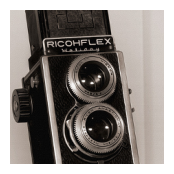

In [26]:
img = imgs[2]
show_device_array(img)

In [27]:
ivy.set_backend("jax")
transpiled_graph = transpile(imagenet_classify, original_backend="jax", to="torch", args=(noise,))

First, we call the original function, which as expected, yields a JAX `DeviceArray` instance.

In [28]:
logits, _ = imagenet_classify(img)
type(logits)

jaxlib.xla_extension.DeviceArray

If we now call the transpiled graph, we can see that the output is, in fact, a `torch.Tensor`, due to the transpiled graph being now fully composed of torch code.

In [29]:
transpiled_logits, _ = transpiled_graph(img)
type(transpiled_logits)

torch.Tensor

Once again, we can check the predictions of both the original and the transpiled model, to see that their results match correctly!

In [30]:
_, indices = ivy.to_numpy(ivy.top_k(logits[0], 5))
probs = ivy.to_numpy(ivy.softmax(logits[0]))
print("Original - Top 5 labels:")
print_labels(probs, indices)

Original - Top 5 labels:
reflex camera       : 0.9125176974309779
Polaroid camera     : 0.0062769926141319965
lens cap            : 0.002572748444021628
tripod              : 0.0013543223305103043
washer              : 0.0008780962522585626


In [31]:
ivy.set_backend("torch")
_, indices = ivy.top_k(transpiled_logits[0], 5)
probs = ivy.to_numpy(ivy.softmax(transpiled_logits[0]))
print("Transpiled - Top 5 labels:")
print_labels(probs, indices)

Transpiled - Top 5 labels:
reflex camera       : 0.9125140905380249
Polaroid camera     : 0.006276924163103104
lens cap            : 0.0025728049222379923
tripod              : 0.0013543171808123589
washer              : 0.0008780973730608821


## Round Up

That's pretty much it! Did you have an Image Augmentation pipeline which used Kornia or some other PyTorch specific package? Maybe some complex meta-learning functions already written in Torch? Now you are free to **use, finetune, or deploy** DeepMind's PerceiverIO model and trained parameters in every framework and every hardware!